<a href="https://colab.research.google.com/github/Pathway2008/Loan_rating/blob/main/classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('/content/drive/MyDrive/loan_rating/train.csv')
test = pd.read_csv('/content/drive/MyDrive/loan_rating/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/loan_rating/sample_submission.csv')

In [ ]:
train = train[train['주택소유상태'] != 'ANY']
train['근로기간'] = train['근로기간'].replace('< 1 year', '<1 year')
train['근로기간'] = train['근로기간'].replace('1 year', '1 years')
train['근로기간'] = train['근로기간'].replace('3', '3 years')
train['근로기간'] = train['근로기간'].replace('10+years', '10+ years')

In [5]:
co = train.copy()

In [6]:
from sklearn.preprocessing import LabelEncoder
ordinal_features = ['대출기간', '근로기간', '주택소유상태','대출목적','대출등급']

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(co[feature])
    co[feature] = le.transform(co[feature])

In [7]:
co.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,0,6,2,72000000,18.90,15,1,0,0,0.0,0.0,0.0,2
1,TRAIN_00001,14400000,1,1,0,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0,1
2,TRAIN_00002,12000000,0,5,0,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0,0
3,TRAIN_00003,14400000,0,8,0,132000000,15.09,15,1,0,325824,153108.0,0.0,0.0,2
4,TRAIN_00004,18000000,1,11,2,71736000,25.39,19,8,0,228540,148956.0,0.0,0.0,1


In [8]:
def map_loan_rating_category(grade):
    if grade in [0,1,2,3,4]:
        return 0
    elif grade in [5,6]:
        return 1
    else:
        return None

co['Loan Category'] = co['대출등급'].apply(map_loan_rating_category)

In [9]:
co.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,Loan Category
0,TRAIN_00000,12480000,0,6,2,72000000,18.90,15,1,0,0,0.0,0.0,0.0,2,0
1,TRAIN_00001,14400000,1,1,0,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0,1,0
2,TRAIN_00002,12000000,0,5,0,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0,0,0
3,TRAIN_00003,14400000,0,8,0,132000000,15.09,15,1,0,325824,153108.0,0.0,0.0,2,0
4,TRAIN_00004,18000000,1,11,2,71736000,25.39,19,8,0,228540,148956.0,0.0,0.0,1,0


In [ ]:
!pip install catboost

In [12]:
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [13]:
X = co.drop(['ID','대출등급', 'Loan Category'], axis=1)
y = co['Loan Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [14]:
# columns_to_scale = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
# X_test_scaled = scaler.transform(X_test[columns_to_scale])

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
xgb_macro = f1_score(y_test, xgb_predictions, average='macro')

# Neural Network
nn_model = MLPClassifier(random_state=42)
nn_model.fit(X_train, y_train)
nn_predictions = nn_model.predict(X_test)
nn_scores = cross_val_score(nn_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
nn_macro = f1_score(y_test, nn_predictions, average='macro')

# CatBoost
cat_model = CatBoostClassifier(random_state=42, verbose=False)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
cat_macro = f1_score(y_test, cat_predictions, average='macro')

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
rf_macro = f1_score(y_test, rf_predictions, average='macro')

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
lgb_macro = f1_score(y_test, lgb_predictions, average='macro')

[LightGBM] [Info] Number of positive: 1644, number of negative: 65761
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1453
[LightGBM] [Info] Number of data points in the train set: 67405, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024390 -> initscore=-3.688895
[LightGBM] [Info] Start training from score -3.688895
[LightGBM] [Info] Number of positive: 1316, number of negative: 52608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 53924, number of used features: 13
[LightGBM] [Info] [b

In [16]:
print(f'XGBoost Cross-Validation F1 Macro: {xgb_scores.mean()}')
print(f'Neural Network Cross-Validation F1 Macro: {nn_scores.mean()}')
print(f'CatBoost Cross-Validation F1 Macro: {cat_scores.mean()}')
print(f'Random Forest Cross-Validation F1 Macro: {rf_scores.mean()}')
print(f'LightGBM Cross-Validation F1 Macro: {lgb_scores.mean()}\n\n\n')

print(f'XGBoost y_test F1 Macro: {xgb_macro}')
print(f'Neural Network y_test F1 Macro: {nn_macro}')
print(f'CatBoost y_test F1 Macro: {cat_macro}')
print(f'Random Forest y_test F1 Macro: {rf_macro}')
print(f'LightGBM y_test F1 Macro: {lgb_macro}')

XGBoost Cross-Validation F1 Macro: 0.8982068127536904
Neural Network Cross-Validation F1 Macro: 0.6158607747876685
CatBoost Cross-Validation F1 Macro: 0.906346080240629
Random Forest Cross-Validation F1 Macro: 0.8153676410271539
LightGBM Cross-Validation F1 Macro: 0.8963401693025442



XGBoost y_test F1 Macro: 0.9058338646574984
Neural Network y_test F1 Macro: 0.8569813373467805
CatBoost y_test F1 Macro: 0.9110734656479493
Random Forest y_test F1 Macro: 0.8493327573902447
LightGBM y_test F1 Macro: 0.9052190447852886


In [19]:
from sklearn.metrics import classification_report
print("Classification Report for Loan Category:")
print('xgb')
print(classification_report(y_test, xgb_predictions),'\n\n')
print('cat')
print(classification_report(y_test, cat_predictions),'\n\n')
print('lgb')
print(classification_report(y_test, lgb_predictions))

Classification Report for Loan Category:
xgb
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     28158
           1       0.88      0.76      0.82       730

    accuracy                           0.99     28888
   macro avg       0.94      0.88      0.91     28888
weighted avg       0.99      0.99      0.99     28888
 


cat
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     28158
           1       0.90      0.77      0.83       730

    accuracy                           0.99     28888
   macro avg       0.95      0.88      0.91     28888
weighted avg       0.99      0.99      0.99     28888
 


lgb
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     28158
           1       0.87      0.76      0.81       730

    accuracy                           0.99     28888
   macro avg       0.93      0.88      0.91     28888
weighted avg   

In [20]:
cat_predictions_flat = np.ravel(cat_predictions)

In [21]:
data = {
    'xgb': xgb_predictions,
    'cat': cat_predictions_flat,
    'lgb': lgb_predictions,
    'sol': y_test

}
pred_total = pd.DataFrame(data)

In [22]:
pred_total.head()

,xgb,cat,lgb,sol
13398,0,0,0,0
75819,0,0,0,0
85612,0,0,0,0
71825,0,0,0,0
27646,0,0,0,0


In [24]:
diff = pred_total[pred_total.apply(lambda row: row.nunique() > 1, axis=1)]
diff

,xgb,cat,lgb,sol
57339,1,1,1,0
62685,1,1,0,1
10567,1,0,0,1
58370,0,0,0,1
16763,1,1,0,1
...,...,...,...,...
34511,0,1,0,1
52271,0,1,1,1
87963,0,0,0,1
89913,0,0,0,1


In [25]:
def majority_vote(row):
    if row.sum() >= 2:
        return 1
    else:
        return 0

# Apply the majority vote function to create the final 'Ensemble Prediction' column
pred_total['ensemble'] = pred_total.apply(majority_vote, axis=1)

In [27]:
print(classification_report(y_test, pred_total['ensemble']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28158
           1       0.90      0.82      0.86       730

    accuracy                           0.99     28888
   macro avg       0.95      0.91      0.93     28888
weighted avg       0.99      0.99      0.99     28888



In [28]:
a5 = pred_total[pred_total['ensemble']==0]
train_a5 = train.loc[a5.index]
train_a5.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
13398,TRAIN_13398,18000000,60 months,5 years,RENT,81000000,21.67,35,신용 카드,0,850284,789696.0,0.0,0.0,C
75819,TRAIN_75819,6000000,36 months,2 years,RENT,72000000,22.86,29,부채 통합,1,596544,168108.0,0.0,0.0,B
85612,TRAIN_85612,38400000,60 months,5 years,MORTGAGE,144000000,17.01,31,주택 개선,0,1500480,925308.0,0.0,0.0,B
71825,TRAIN_71825,19200000,36 months,10+ years,MORTGAGE,120000000,28.74,28,신용 카드,0,975252,190488.0,0.0,0.0,A
27646,TRAIN_27646,24000000,60 months,10+ years,MORTGAGE,114000000,16.28,21,부채 통합,0,586176,472224.0,0.0,0.0,C


In [29]:
f2 = pred_total[pred_total['ensemble']==1]
train_f2 = train.loc[f2.index]
train_f2.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
68416,TRAIN_68416,18120000,60 months,10+ years,OWN,50400000,10.26,5,부채 통합,0,673284,1346400.0,0.0,0.0,F
48840,TRAIN_48840,42000000,60 months,3 years,OWN,120000000,18.42,59,주택 개선,2,1009728,2774196.0,0.0,0.0,G
40663,TRAIN_40663,16530000,60 months,Unknown,MORTGAGE,90000000,17.65,40,부채 통합,0,278244,707280.0,0.0,0.0,F
95417,TRAIN_95417,26430000,60 months,2 years,RENT,73200000,35.41,21,주요 구매,0,750072,1581372.0,0.0,0.0,F
74548,TRAIN_74548,18300000,60 months,10+ years,OWN,78000000,5.06,30,기타,0,643464,1453824.0,0.0,0.0,F


In [33]:
new = train.loc[pred_total.index]

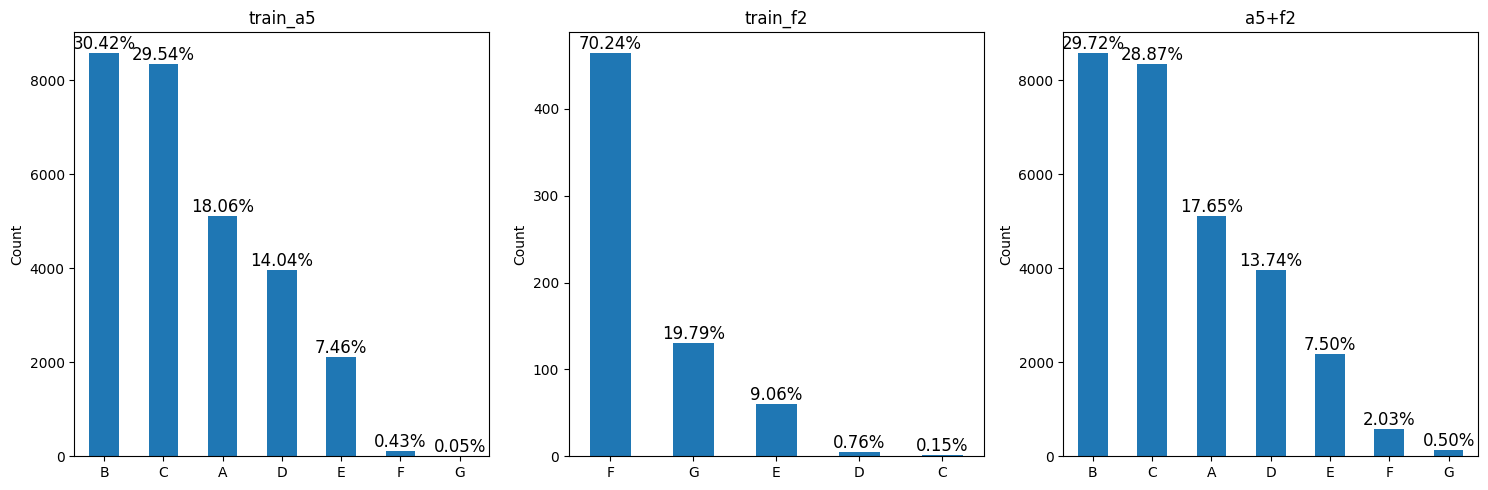

In [34]:
import matplotlib.pyplot as plt

def plot_loan_grade_percentage(df, title, ax):
    value_counts = df['대출등급'].value_counts()
    value_counts.plot(kind='bar', ax=ax, title=title)

    total = len(df)
    for i, value in enumerate(value_counts):
        ax.text(i, value, f'{(value/total)*100:.2f}%', ha='center', va='bottom', fontsize=12)

    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='horizontal')
    ax.set_ylabel('Count')

# List of DataFrames and corresponding titles
dfs = [train_a5,train_f2,new]
titles = ['train_a5','train_f2','a5+f2']

# Create a single row with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through DataFrames, titles, and subplots for plotting
for df, title, ax in zip(dfs, titles, axes):
    plot_loan_grade_percentage(df, title, ax)

plt.tight_layout()
plt.show()

# classifier_level2

In [60]:
co_5 = co[co['대출등급']/5<1]
co_3 = co[co['대출등급']/5>=0.8]

In [54]:
X = co_5.drop(['ID','대출등급', 'Loan Category'], axis=1)
y = co_5['대출등급']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [55]:
# columns_to_scale = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
# X_test_scaled = scaler.transform(X_test[columns_to_scale])

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=43)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
xgb_macro = f1_score(y_test, xgb_predictions, average='macro')

# CatBoost
cat_model = CatBoostClassifier(random_state=43, verbose=False)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
cat_macro = f1_score(y_test, cat_predictions, average='macro')

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=43)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
lgb_macro = f1_score(y_test, lgb_predictions, average='macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 65743, number of used features: 13
[LightGBM] [Info] Start training from score -1.728560
[LightGBM] [Info] Start training from score -1.177747
[LightGBM] [Info] Start training from score -1.220274
[LightGBM] [Info] Start training from score -1.959833
[LightGBM] [Info] Start training from score -2.545204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 52594, number of used features: 13
[LightGBM] [Info] Start training from score -1.728510
[LightGBM] [Info] Start training f

In [57]:
print(f'XGBoost Cross-Validation F1 Macro: {xgb_scores.mean()}')
print(f'CatBoost Cross-Validation F1 Macro: {cat_scores.mean()}')
print(f'LightGBM Cross-Validation F1 Macro: {lgb_scores.mean()}\n\n\n')

print(f'XGBoost y_test F1 Macro: {xgb_macro}')
print(f'CatBoost y_test F1 Macro: {cat_macro}')
print(f'LightGBM y_test F1 Macro: {lgb_macro}')

XGBoost Cross-Validation F1 Macro: 0.8415462358526693
CatBoost Cross-Validation F1 Macro: 0.8203543209781392
LightGBM Cross-Validation F1 Macro: 0.8350880685612119



XGBoost y_test F1 Macro: 0.8449861907861124
CatBoost y_test F1 Macro: 0.8245141772236882
LightGBM y_test F1 Macro: 0.837367666268824


In [58]:
from sklearn.metrics import classification_report
print("Classification Report for Loan Category:")
print('xgb')
print(classification_report(y_test, xgb_predictions),'\n\n')
print('cat')
print(classification_report(y_test, cat_predictions),'\n\n')
print('lgb')
print(classification_report(y_test, lgb_predictions))

Classification Report for Loan Category:
xgb
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5100
           1       0.85      0.87      0.86      8570
           2       0.86      0.89      0.87      8218
           3       0.82      0.79      0.81      4092
           4       0.83      0.77      0.80      2196

    accuracy                           0.86     28176
   macro avg       0.85      0.84      0.84     28176
weighted avg       0.86      0.86      0.86     28176
 


cat
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      5100
           1       0.84      0.86      0.85      8570
           2       0.84      0.89      0.86      8218
           3       0.79      0.78      0.78      4092
           4       0.85      0.68      0.76      2196

    accuracy                           0.84     28176
   macro avg       0.84      0.81      0.82     28176
weighted avg       0.84  

In [69]:
class_mapping = {4: 0, 5: 1, 6: 2}  # Adjust as needed

# Apply the mapping to y_train
co_3['대출등급'] = co_3['대출등급'].map(class_mapping)
co_3['대출등급'].unique()

<ipython-input-69-a8ea00f159b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co_3['대출등급'] = co_3['대출등급'].map(class_mapping)


array([1, 2, 0])

In [70]:
X = co_3.drop(['ID','대출등급', 'Loan Category'], axis=1)
y = co_3['대출등급']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

In [71]:
# columns_to_scale = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
# X_test_scaled = scaler.transform(X_test[columns_to_scale])

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=44)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
xgb_macro = f1_score(y_test, xgb_predictions, average='macro')

# CatBoost
cat_model = CatBoostClassifier(random_state=44, verbose=False)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
cat_macro = f1_score(y_test, cat_predictions, average='macro')

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=44)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_macro')
lgb_macro = f1_score(y_test, lgb_predictions, average='macro')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1400
[LightGBM] [Info] Number of data points in the train set: 6809, number of used features: 13
[LightGBM] [Info] Start training from score -0.274599
[LightGBM] [Info] Start training from score -1.623339
[LightGBM] [Info] Start training from score -3.149247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1385
[LightGBM] [Info] Number of data points in the train set: 5447, number of used features: 12
[LightGBM] [Info] Start training from score -0.274611
[LightGBM] [Info] Start training from score -1.623675
[LightGBM] [Info] Start training from score -3.147499
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 secon

In [72]:
print(f'XGBoost Cross-Validation F1 Macro: {xgb_scores.mean()}')
print(f'CatBoost Cross-Validation F1 Macro: {cat_scores.mean()}')
print(f'LightGBM Cross-Validation F1 Macro: {lgb_scores.mean()}\n\n\n')

print(f'XGBoost y_test F1 Macro: {xgb_macro}')
print(f'CatBoost y_test F1 Macro: {cat_macro}')
print(f'LightGBM y_test F1 Macro: {lgb_macro}')

XGBoost Cross-Validation F1 Macro: 0.7370421488056093
CatBoost Cross-Validation F1 Macro: 0.7105093090246847
LightGBM Cross-Validation F1 Macro: 0.7447945064439784



XGBoost y_test F1 Macro: 0.7856520425888208
CatBoost y_test F1 Macro: 0.761765064670023
LightGBM y_test F1 Macro: 0.7650870968570586


In [73]:
from sklearn.metrics import classification_report
print("Classification Report for Loan Category:")
print('xgb')
print(classification_report(y_test, xgb_predictions),'\n\n')
print('cat')
print(classification_report(y_test, cat_predictions),'\n\n')
print('lgb')
print(classification_report(y_test, lgb_predictions))

Classification Report for Loan Category:
xgb
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2180
           1       0.82      0.71      0.76       611
           2       0.81      0.54      0.65       128

    accuracy                           0.90      2919
   macro avg       0.85      0.74      0.79      2919
weighted avg       0.90      0.90      0.90      2919
 


cat
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2180
           1       0.82      0.67      0.73       611
           2       0.84      0.48      0.61       128

    accuracy                           0.89      2919
   macro avg       0.85      0.71      0.76      2919
weighted avg       0.89      0.89      0.89      2919
 


lgb
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2180
           1       0.82      0.69      0.75       611
           2    